# Python segmentation integration test

Make some test data for segmentation and test algorithm implementation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

np.random.seed(12348)

# Set up constants

In [2]:
# duration stuff

T = 5  # total duration (in s)
dt = 0.05  # bin size (in s)
Nt = int(np.ceil(T / dt))

mu = 0.5  # mean state duration (in s)
sig = 0.05  # standard deviation of state duration (in s)

In [3]:
# rates
lam = 1.  # baseline rate (Hz)
nu = 1000.  # rate multiplier (Hz)

# Make some intervals

In [4]:
durations = mu + sig * np.random.randn(Nt)
changepoints = np.cumsum(durations)
maxind = np.argwhere(changepoints > T)[0, 0]
changepoints = changepoints[:maxind]

In [5]:
changepoints / dt

array([ 11.3095624 ,  19.66190965,  29.58543266,  38.02284812,
        49.67895912,  57.83183378,  67.24225904,  78.0745227 ,
        87.89415731,  98.893017  ])

In [6]:
taxis = np.arange(0, T, dt)
states = np.zeros(Nt)
rates = lam * np.ones(Nt)

In [7]:
for idx in xrange(0, len(changepoints), 2):
    if idx == len(changepoints) - 1:
        upper = T
    else:
        upper = changepoints[idx + 1]
    in_state_1 = (changepoints[idx] < taxis) & (taxis < upper)
    states[in_state_1] = 1
    rates[in_state_1] = nu * lam

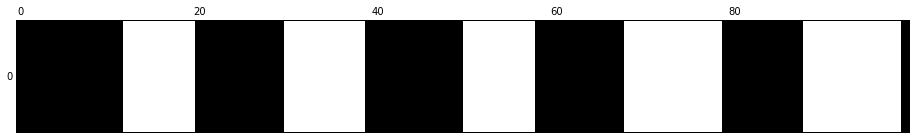

In [8]:
plt.matshow(states[np.newaxis, :], cmap="gray", aspect="auto");

# Make counts

[ 0  0  0  0  0  0  0  0  0  0  0  0 44 48 58 53 38 47 50 47  0  0  1  0  0
  0  0  0  0  1 62 48 54 46 61 51 48 56 58  0  0  0  0  0  0  0  0  0  0  0
 52 54 53 41 49 36 61 50  0  0  0  0  0  0  0  0  0  0 45 58 45 47 45 55 62
 45 58 43 64  0  0  0  0  0  0  0  0  0 60 47 45 47 46 58 53 45 45 57 53  0]


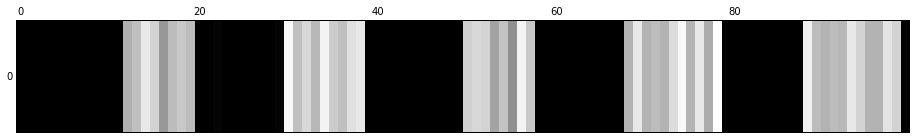

In [9]:
counts = stats.poisson.rvs(rates * dt)

plt.matshow(counts[np.newaxis, :], cmap="gray", aspect="auto")

print counts

# Define some useful functions

In [10]:
def grab_ss(t1, t2):
    """
    Given start and end times t1 and t2, get sufficient statistics for data
    in the closed interval [t1, t2].  
    """
    this_counts = counts[t1:(t2 + 1)]
    return sum(this_counts), len(this_counts)

In [11]:
def base_LL(t1, t2):
    c = counts[t1:(t2 + 1)]
    return np.sum(stats.poisson.logpmf(c, lam * dt))

In [12]:
def kappa(N, ell):
    return N * np.log(nu) - lam * dt * (nu - 1) * ell

In [13]:
def C(t1, t2):
    N, ell = grab_ss(t1, t2)
    kap = kappa(N, ell)
    return -(base_LL(t1, t2) + kap + np.logaddexp(0, -kap))

# Run inference

In [14]:
T = len(counts)  # number of time points
F = np.empty(T + 1)  # F(t) = minimum cost for all data up to time t
R = set({})  # set of times over which to search
CP = set({})  # list of changepoints (ordered)
beta = 2.  # penalty per changepoint
K = 0.0  # bound constant for objective gain on changepoint insertion

Now initialize $F(0)$ and $R$:

In [15]:
R.add(0)
F[0] = -beta

In [16]:
for tau in xrange(1, T + 1):
    mincost = np.inf
    new_tau = 0
    for t in R:
        cost = F[t] + C(t + 1, tau) + beta
        if cost < mincost:
            mincost = cost
            new_tau = t
            
    F[tau] = mincost
    
    CP.add(new_tau)
    R = {r for r in R if F[r] + C(r + 1, tau) + K < F[tau]}
    R.add(tau)

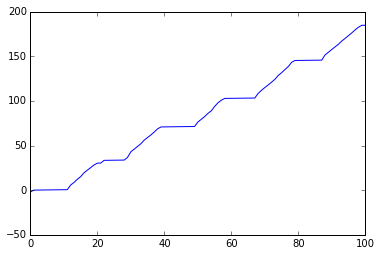

In [17]:
plt.plot(F);

In [18]:
cplist = list(CP)
cplist.sort()
Ncp = len(cplist)
inferred = np.empty(T)

for tau in xrange(Ncp):
    run_start = cplist[tau] + 1
    if tau == Ncp - 1:
        run_end = T
    else:
        run_end = cplist[tau + 1]
        
    kap = kappa(*grab_ss(run_start, run_end))
    Ez = stats.logistic.cdf(kap)
    inferred[run_start:(run_end + 1)] = Ez

In [19]:
changepoints / dt , np.array(cplist)

(array([ 11.3095624 ,  19.66190965,  29.58543266,  38.02284812,
         49.67895912,  57.83183378,  67.24225904,  78.0745227 ,
         87.89415731,  98.893017  ]),
 array([ 0, 11, 19, 29, 38, 49, 57, 67, 78, 87, 98]))

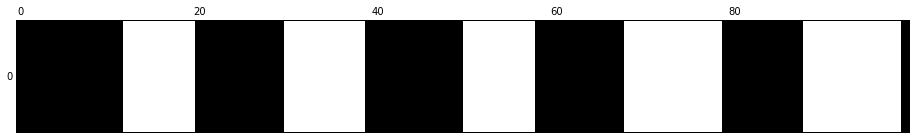

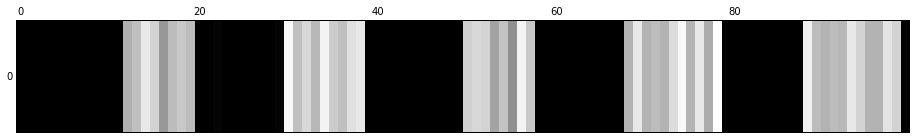

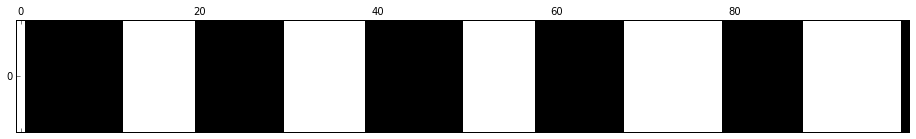

In [20]:
plt.matshow(states[np.newaxis, :], cmap="gray", aspect="auto", clim=(0, 1))
plt.matshow(counts[np.newaxis, :], cmap="gray", aspect="auto")
plt.matshow(inferred[np.newaxis, :], cmap="gray", aspect="auto", clim=(0, 1));